In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

crimes_schema = StructType([StructField("INCIDENT_NUMBER", StringType(), True),
                            StructField("OFFENSE_CODE", StringType(), True),
                            StructField("OFFENSE_CODE_GROUP", StringType(), True),
                            StructField("OFFENSE_DESCRIPTION", StringType(), True),
                            StructField("DISTRICT", StringType(), True),
                            StructField("REPORTING_AREA", StringType(), True),
                            StructField("SHOOTING", StringType(), True),
                            StructField("OCCURRED_ON_DATE", TimestampType(), True),
                            StructField("YEAR", IntegerType(), True),
                            StructField("MONTH", IntegerType(), True),
                            StructField("DAY_OF_WEEK", StringType(), True),
                            StructField("HOUR", IntegerType(), True),
                            StructField("UCR_PART",StringType(), True),
                            StructField("STREET", StringType(), True),
                            StructField("Lat", StringType(), True),
                            StructField("Long", StringType(), True),
                            StructField("Location", StringType(), True)])

spark = SparkSession.builder.appName("Crimes in boston").getOrCreate()

crimes = spark.read.csv("./data/BostenCrime.csv", header = True, schema = crimes_schema)

In [2]:
Years = crimes.select("YEAR").distinct().sort("YEAR", ascending = False).take(10)

Years

[Row(YEAR=2019),
 Row(YEAR=2018),
 Row(YEAR=2017),
 Row(YEAR=2016),
 Row(YEAR=2015)]

In [3]:
crimes

DataFrame[INCIDENT_NUMBER: string, OFFENSE_CODE: string, OFFENSE_CODE_GROUP: string, OFFENSE_DESCRIPTION: string, DISTRICT: string, REPORTING_AREA: string, SHOOTING: string, OCCURRED_ON_DATE: timestamp, YEAR: int, MONTH: int, DAY_OF_WEEK: string, HOUR: int, UCR_PART: string, STREET: string, Lat: string, Long: string, Location: string]

In [4]:
crimes.groupBy("Month").count().orderBy("MONTH").show(12)
crimes.groupBy("YEAR").count().orderBy("YEAR").show()

+-----+-----+
|Month|count|
+-----+-----+
|    1|31549|
|    2|28695|
|    3|32093|
|    4|31867|
|    5|35098|
|    6|39293|
|    7|43853|
|    8|44732|
|    9|42571|
|   10|34286|
|   11|31460|
|   12|31323|
+-----+-----+

+----+------+
|YEAR| count|
+----+------+
|2015| 53597|
|2016| 99430|
|2017|101338|
|2018| 98888|
|2019| 73567|
+----+------+



In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_crime_per_hour_perMonth(hour):

    x_axis = [i+1 for i in range(11)]
    y_axis = []
    
    result = crimes.filter("HOUR="+hour).groupBy("MONTH").count().orderBy("MONTH")
    data = result.take(12)
    for i in range(1, 12):
        y_axis.append(data[i-1][1])

    fig1 = plt.figure(figsize=(7, 7))
    fig1.suptitle('Crimes per month per within a hour', fontsize=14)
    ax = fig1.add_subplot(111)
    ax.set_xlabel('month')
    ax.set_ylabel('Crime')
    ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
    plt.show()
    
    return

In [6]:
from IPython.display import HTML

time = '12'

form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Hour : <input id='hour' type='range' min='0' max='23' step='1' value='12' onchange='set_vars()'/>
</div>"""

javascript = """
<script type="text/Javascript">
    const kernelCell = 6;

    function set_vars(){
        var time = document.getElementById('hour').value;
        var kernel = IPython.notebook.kernel;
        
        kernel.execute('time = "' + time + '"');
        cell = IPython.notebook.get_cell(kernelCell);
        cell.execute();
        cell.focus_cell(kernelCell);
    }
</script>
"""

HTML(form + javascript)

Time: 12


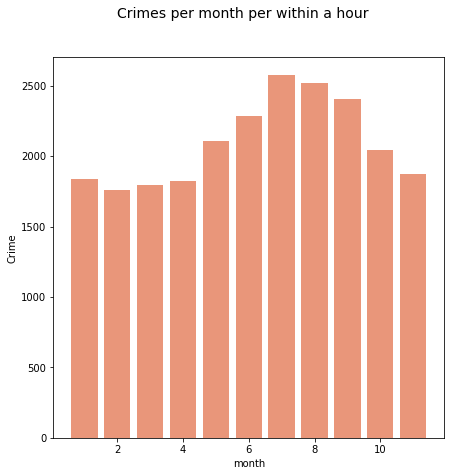

In [7]:
print('Time: ' + str(time))
show_crime_per_hour_perMonth(time)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

print("Crime per hour")

x_axis = [i for i in range(24)]
y_axis = []

result = crimes.groupBy("Hour").count().orderBy("HOUR")

data = result.take(24)
for i in range(0, 24):
    y_axis.append(data[i][1])

Crime per hour


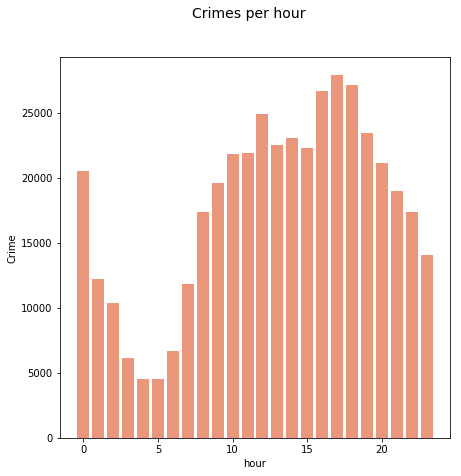

In [9]:
y_axis
    
fig1 = plt.figure(figsize=(7, 7))
fig1.suptitle('Crimes per hour', fontsize=14)
ax = fig1.add_subplot(111)
ax.set_xlabel('hour')
ax.set_ylabel('Crime')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

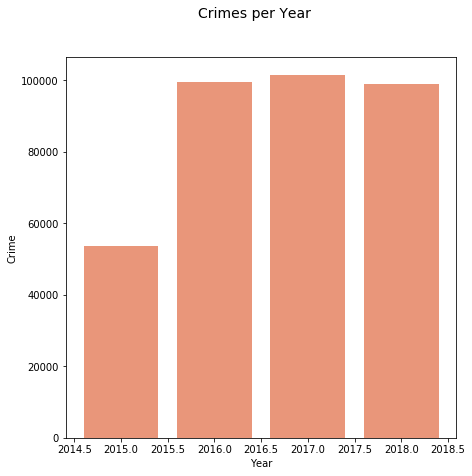

In [10]:
x_axis = []
y_axis = []

result = crimes.groupBy("YEAR").count().orderBy("YEAR")

data = result.take(4)

for i in range(0,4):
    x_axis.append(data[i][0])
    y_axis.append(data[i][1])

fig1 = plt.figure(figsize=(7, 7))
fig1.suptitle('Crimes per Year', fontsize=14)
ax = fig1.add_subplot(111)
ax.set_xlabel('Year')
ax.set_ylabel('Crime')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

In [11]:
from folium.plugins import HeatMap
import folium

def getData(item):
    try:
        return [float(item[0]), float(item[1])]
    except:
        return [0, 0]

crime_long_lat  = crimes.groupBy("Lat","Long").count().sort('count', ascending  = False).limit(9999).collect()
crime_long_lat.pop(0)
long_lat = [getData(item) for item in crime_long_lat]


first_map = folium.Map(
    location=[42.34862382, -71.08277637],
    tiles='Stamen Toner',
    zoom_start=13
)
HeatMap(long_lat,name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=10, gradient=None, overlay=True, control=True, show=True).add_to(first_map)

first_map

/usr/local/lib/python2.7/dist-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


In [12]:
def displayMap(year):
    crime_long_lat  = crimes.filter("YEAR="+year).groupBy("Lat","Long").count().sort('count', ascending  = False).limit(9999).collect()
    crime_long_lat.pop(0)
    long_lat = [getData(item) for item in crime_long_lat]

    yearMap = folium.Map(
        location=[42.34862382, -71.08277637],
        tiles='Stamen Toner',
        zoom_start=13
    )
    HeatMap(long_lat,name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=10, gradient=None, overlay=True, control=True, show=True).add_to(yearMap)

    return yearMap

In [13]:
form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Year : <input id='year' type='range' min='"""+ str(Years[0][0] - len(Years) + 1) + """' max='"""+ str(Years[0][0]) + """' step='1' value='"""+ str(Years[0][0] - len(Years) + 2) + """' onchange='set_year()'/>
</div>"""

javascript = """
<script type="text/Javascript">
    let yearCell = 13;

    function set_year(){
        var time = document.getElementById('year').value;
        var kernel = IPython.notebook.kernel;
        
        kernel.execute('year = "' + time + '"');
        cell = IPython.notebook.get_cell(yearCell);
        cell.execute();
        cell.focus_cell(yearCell);
    }
</script>
"""

year = '2016'

#Years[0][0] - len(Years) - 1
HTML(form + javascript)

In [14]:
print("Heat map of Year: " + str(year))

yearMap = displayMap(year)
yearMap

Heat map of Year: 2016


In [15]:
result = crimes.groupBy("DISTRICT").count().orderBy("DISTRICT")
result.show()

+--------+-----+
|DISTRICT|count|
+--------+-----+
|    null| 2170|
|      A1|47713|
|     A15| 8643|
|      A7|17173|
|      B2|67965|
|      B3|48271|
|     C11|57306|
|      C6|31043|
|     D14|26811|
|      D4|55167|
|     E13|23442|
|     E18|23370|
|      E5|17746|
+--------+-----+



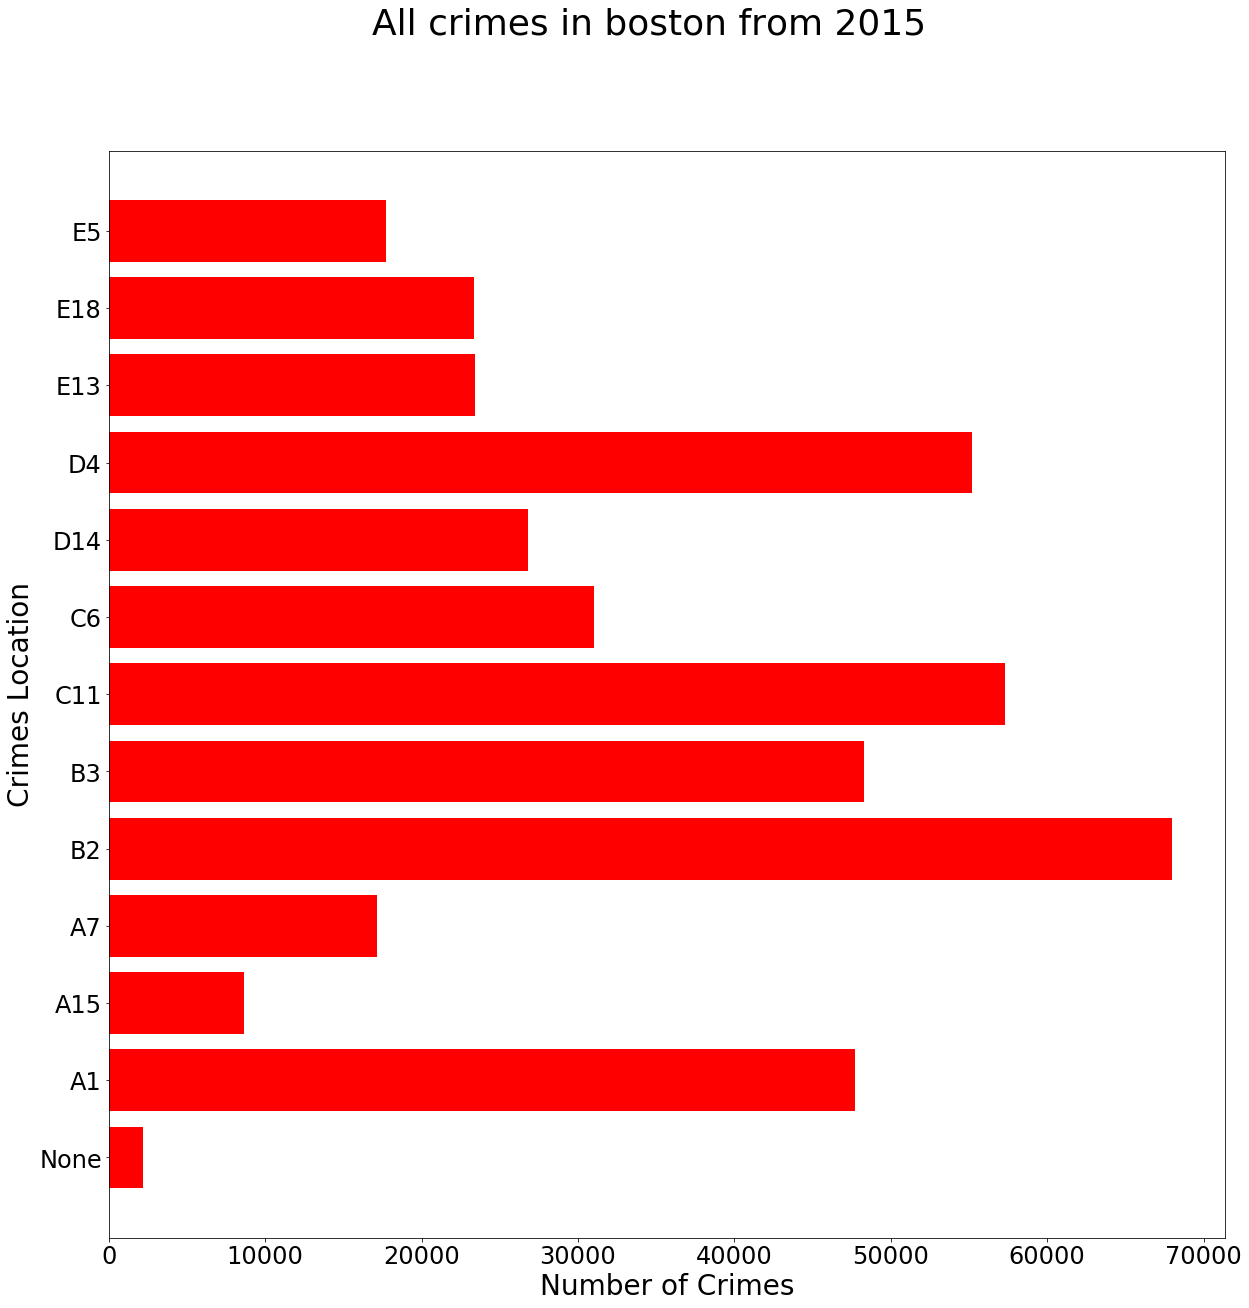

In [16]:
location = [str(item[0]) for item in result.limit(20).collect()]
count = [item[1] for item in result.limit(20).collect()]

x_axis = [i for i in location] 
y_axis= [i for i in count]

fig = plt.figure(figsize=(20,20))
fig.suptitle('All crimes in boston from 2015', fontsize=36)
 
plt.xlabel("Number of Crimes", fontsize = 28)
plt.ylabel("Crimes Location", fontsize = 28)
plt.barh(x_axis,y_axis,color = "red")
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.show()

In [17]:
result = crimes.groupBy("SHOOTING").count().orderBy("count")
result.show()

+--------+------+
|SHOOTING| count|
+--------+------+
|       Y|  1747|
|    null|425073|
+--------+------+



In [20]:
result = crimes.groupBy("OFFENSE_DESCRIPTION").count().filter("count > 1000").sort('count', ascending  = True)
result.show()

+--------------------+-----+
| OFFENSE_DESCRIPTION|count|
+--------------------+-----+
|DISTURBING THE PEACE| 1009|
|DRUGS - POSS CLASS D| 1031|
|M/V ACCIDENT - PO...| 1051|
|AUTO THEFT - MOTO...| 1104|
|BURGLARY - COMMER...| 1122|
|PROPERTY - ACCIDE...| 1181|
|M/V ACCIDENT - IN...| 1191|
|  PROPERTY - MISSING| 1193|
|DRUGS - POSS CLAS...| 1255|
|LIQUOR - DRINKING...| 1279|
|WEAPON - FIREARM ...| 1287|
|      SEARCH WARRANT| 1315|
|STOLEN PROPERTY -...| 1322|
|LANDLORD - TENANT...| 1332|
|BALLISTICS EVIDEN...| 1338|
|    ASSAULT - SIMPLE| 1366|
|RECOVERED - MV RE...| 1384|
|VAL - OPERATING U...| 1404|
|DRUGS - SICK ASSI...| 1477|
|       DRUGS - OTHER| 1506|
+--------------------+-----+
only showing top 20 rows



In [21]:
location = [str(item[0]) for item in result.limit(10).collect()]
count = [item[1] for item in result.limit(10).collect()]

x_axis = [i for i in location] 
y_axis= [i for i in count]

fig = plt.figure(figsize=(20,20))
fig.suptitle('All crimes in boston from 2015', fontsize=36)
 
plt.xlabel("Number of Crimes", fontsize = 28)
plt.ylabel("Crimes Location", fontsize = 28)
plt.barh(x_axis,y_axis,color = "red")
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.show()

UnicodeEncodeError: 'ascii' codec can't encode character u'\xa0' in position 25: ordinal not in range(128)